<a href="https://colab.research.google.com/github/PatrickRedStar/analysis3k1s/blob/main/%D0%97%D0%B0%D1%87%D1%91%D1%82_3%D0%BA1%D1%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ медицинского датасета** 

Всем привет! В своем проекте мы хотели рассмотреть набор данных, который посвящен сердечной недостаточности пациентов.


#**Постановка проблемы**


Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти номер 1 во всем мире, унося примерно 17,9 миллиона жизней ежегодно, что составляет 31% всех смертей в мире. Четыре из 5 смертей от сердечно-сосудистых заболеваний связаны с сердечными приступами и инсультами, и одна треть этих смертей происходит преждевременно среди людей в возрасте до 70 лет.
Сердечная недостаточность является распространенным явлением, вызванным сердечно-сосудистыми заболеваниями, и этот набор данных содержит 11 признаков, которые можно использовать для прогнозирования возможного заболевания сердца.

Люди с сердечно-сосудистыми заболеваниями или с высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет,
гиперлипидемия или уже установленное заболевание) нуждаются в раннем выявлении и лечении, в чем большую помощь может оказать модель машинного обучения.

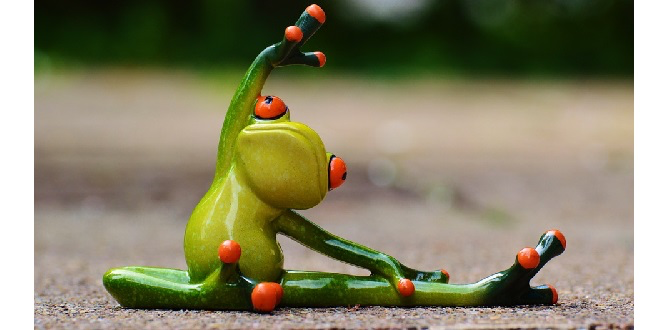

Датасет: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/code?datasetId=1582403&searchQuery=py

# **Датасет**

- Age: возраст пациента [лет]
- Sex: пол пациента [М: Мужской, Ж: Женский]
- ChestPainType: тип боли в груди [TA: типичная стенокардия, ATA: атипичная стенокардия, NAP: неангинальная боль, ASY: бессимптомная]
- RestingBP: артериальное давление в состоянии покоя [мм рт.ст.]
- Cholesterol: холестерин сыворотки [мм/дл]
- FastingBS: уровень сахара в крови натощак [1: если FastingBS > 120 мг/дл, 0: иначе]
- RestingECG: результаты электрокардиограммы в покое [норма: нормальная, ST: аномалия ST-T (инверсия зубца T и/или подъем или депрессия ST > 0,05 мВ), ГЛЖ: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса]
- MaxHR: максимальная достигнутая частота сердечных сокращений [Числовое значение от 60 до 202]
- ExerciseAngina: [Д: Да, Н: Нет]
- Oldpeak: старый пик = ST [Числовое значение, измеренное в депрессии]
- ST_Slope: наклон сегмента ST пикового упражнения [Вверх: восходящий, Плоский: плоский, Вниз: нисходящий]
- HeartDisease: выходной класс [1: болезнь сердца, 0: нормальный]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix,classification_report,f1_score

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Нам крупно повезло,потому что в датасете нет "Nan")))))

# **EDA**

In [ ]:
df.shape

(918, 12)

In [ ]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
df["Sex"] = df["Sex"].map({"M": "Male", "F": "Female"})
df["Sex"]
df["HeartDisease"] = df["HeartDisease"].map({0: "No", 1: "Yes"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 86.2+ KB


In [ ]:
sex_counts = df["Sex"].value_counts(normalize=True).round(2) * 100
sex_counts = sex_counts.reset_index().rename(columns={"Sex": "Pct", "index": "Sex"})
sex_counts

,Sex,Pct
0,Male,79.0
1,Female,21.0


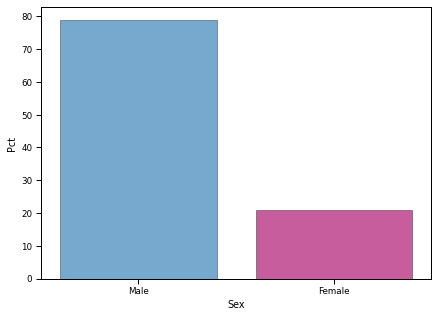

In [ ]:
plt.figure(figsize=(7, 5))
sns.set_context("paper")

sex_color = dict({"Male": "#2986cc", "Female": "#c90076"})

ax1 = sns.barplot(
    data=sex_counts,
    x="Sex",
    y="Pct",
    palette=sex_color,
    linewidth=0.5,
    edgecolor="black",
    alpha=0.7,
)

plt.show()

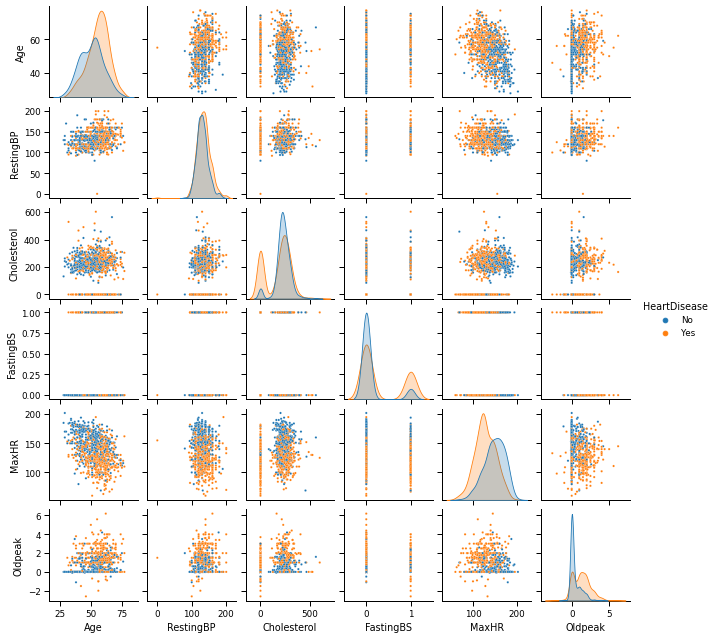

In [ ]:
sns.pairplot(
    df,
    hue="HeartDisease",
    kind="scatter",
    diag_kind="kde",
    height=1.5,
    aspect=1,
    plot_kws=dict(s=5),
)
plt.show()

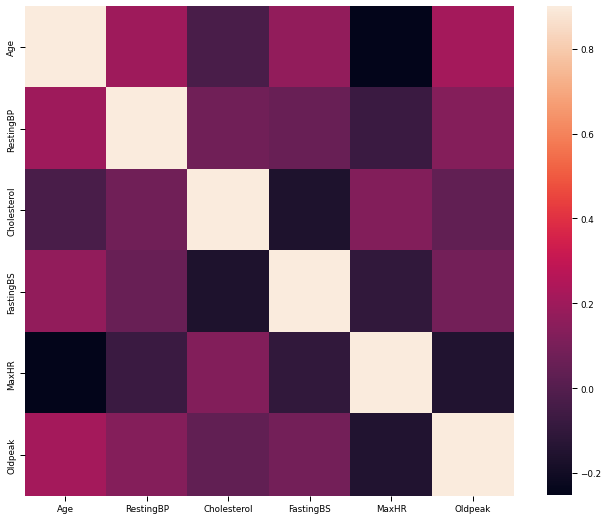

In [ ]:
import seaborn as sns
corrmat = df.corr(method='kendall')
plt.subplots(figsize=(12,9))

sns.heatmap(corrmat, vmax=0.9, square=True)

**Вывод: корреляции не так много**

Как мы можем заметить сильная корреляция наблюдается c возврастом пациента


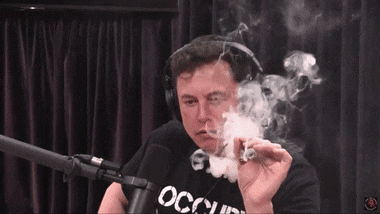

Просим обратить внимание, что женщины кодируются символом 0, а мужчины - 1. А также стенокардия при физической нагрузке, если она есть, то - 1, нет - 0

In [ ]:
df.Sex = df.Sex.map({"Male":1,"Female":0})
df.ExerciseAngina = df.ExerciseAngina.map({"Y":1,"N":0})
df.HeartDisease = df.HeartDisease.map({"Yes":1,"No":0})

In [ ]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144,193,1,Normal,141,0,3.4,Flat,1
915,57,1,ASY,130,131,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130,236,0,LVH,174,0,0.0,Flat,1


In [ ]:
data = df.drop(['HeartDisease'],axis=1)
data = pd.get_dummies(data, drop_first=True)

# **Построение модели**

In [ ]:
X = data.values
y = df.HeartDisease.values

In [ ]:
scaler = StandardScaler()
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [ ]:
bSize = 256

xtrain = torch.tensor(xtrain).float()
ytrain = torch.tensor(ytrain).float().reshape(-1,1)

xtest = torch.tensor(xtest).float()
ytest = torch.tensor(ytest).float().reshape(-1,1)

#create tensordataset
trainData = TensorDataset(xtrain,ytrain)
testData = TensorDataset(xtest,ytest)

#creating data loader
trainLoader = DataLoader(trainData,batch_size=bSize,shuffle=True,drop_last=True)
testLoader = DataLoader(testData,batch_size=testData.tensors[0].shape[0])

print(f"No of traing samples : {len(trainLoader.dataset)}\nNo of test samples: {len(testLoader.dataset)}")

No of traing samples : 734
No of test samples: 184


In [ ]:
trainData.tensors[0].size()

torch.Size([734, 15])

In [ ]:
class TheModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        #input layer
        self.input = nn.Linear(15,100)
        
        #hidden layer
        self.fc1 = nn.Linear(100,100)
        self.bnnorm1 = nn.BatchNorm1d(100)
        
        #output layer
        self.output = nn.Linear(100,1)
        self.dr = 0.2
    
    def forward(self,x):
        
        x = F.relu(self.input(x))
        x = F.dropout(x,p=self.dr,training=self.training)
        
        x = self.bnnorm1(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=self.dr,training=self.training)
        
        return self.output(x)

https://androidkt.com/difference-between-bceloss-and-bcewithlogitsloss-in-pytorch/

Бинарная перекрестная энтропия с потерями логитов объединяет сигмовидный слой и BCELoss в одном классе. Это более численно стабильно, чем использование простой сигмоиды, за которой следует BCELoss, поскольку, объединяя операции в один слой, мы используем трюк log-sum-exp для численной стабильности.

Optimized for Adam: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

In [ ]:
def createModel(lr):
    net = TheModel()
    lossFunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    return net,lossFunc,optimizer

In [ ]:
#test for ranom sample
createModel(0.1)[0](torch.randn(10,15))

tensor([[ 0.1489],
        [ 0.7811],
        [ 0.4395],
        [ 0.1001],
        [ 0.1294],
        [ 0.0018],
        [ 0.3831],
        [-0.1992],
        [ 0.3768],
        [ 0.1889]], grad_fn=<AddmmBackward0>)

In [ ]:
def trainModel(lr,epoch):
    
    trainAccuracy = torch.zeros(epoch)
    testAccuracy = torch.zeros(epoch)
    
    net,lossFunc,optimizer = createModel(lr)
    
    for i in range(epoch):
        for X,y in trainLoader:
            batchAccuracy = []
            net.train()
            
            #forward pass
            yHat = net(X)
            loss = lossFunc(yHat,y)
            yHat = (yHat>0).float()
            batchAccuracy.append(100*torch.mean((yHat==y).float()).item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        trainAccuracy[i] = np.mean(batchAccuracy)
        net.eval()
        X,y = next(iter(testLoader))
        yHat = net(X)
        loss = lossFunc(yHat,y)
        yHat = (yHat>0).float()
        testAccuracy[i] = 100*torch.mean((y==yHat).float()).item()
    return net,testAccuracy,trainAccuracy

In [ ]:
net, testAccuracy, trainAccuracy = trainModel(0.001,50)

# **Оценка модели**

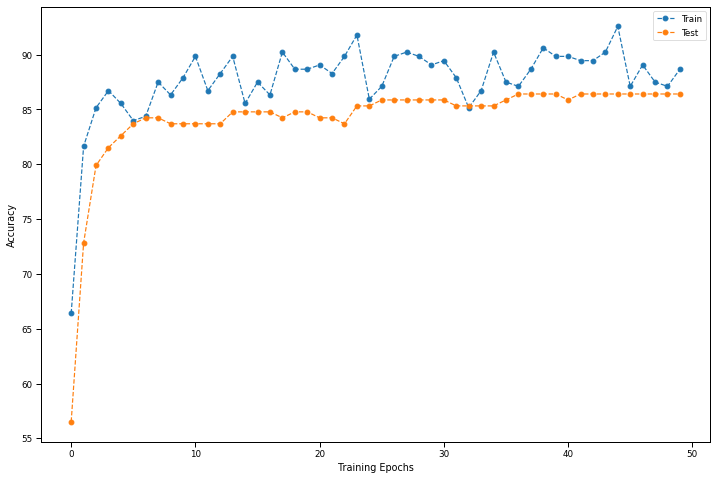

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(trainAccuracy,'o--',label='Train')
plt.plot(testAccuracy,'o--',label='Test')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# predictions for testset
X,y = next(iter(testLoader))
yHat = net(X)
testPreds = (yHat>0).float()

#predictions for trainset
trainPreds = (net(trainLoader.dataset.tensors[0])>1).float()

#confusion metrics
trainConf = confusion_matrix(trainLoader.dataset.tensors[1],trainPreds)
testConf = confusion_matrix(y,testPreds)

In [ ]:
#calculating f1 score
f1Test = f1_score(y,testPreds)
f1Train = f1_score(trainLoader.dataset.tensors[1],trainPreds)

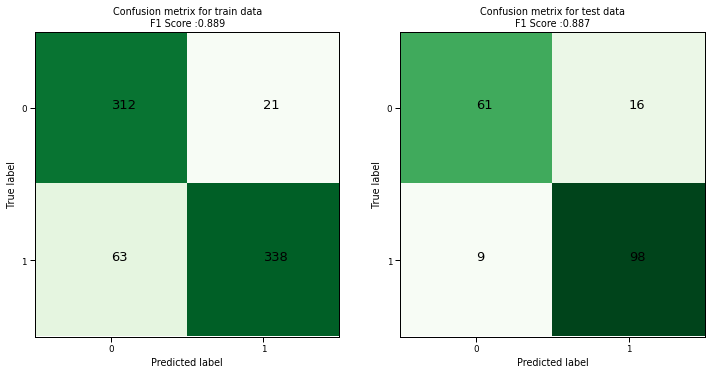

In [ ]:
#plot confusion metrix for train and test sets
fig,ax = plt.subplots(1,2,figsize=(12,8))
#increasing font size little-bit
plt.rcParams.update({'font.size':13})

ax[0].set_title(f"Confusion metrix for train data\nF1 Score :{f1Train:.3f}")
ax[0].imshow(trainConf,'Greens',vmax=len(trainPreds)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")

ax[0].text(0,0,trainConf[0,0])
ax[0].text(0,1,trainConf[1,0])
ax[0].text(1,0,trainConf[0,1])
ax[0].text(1,1,trainConf[1,1])


ax[1].set_title(f"Confusion metrix for test data\nF1 Score :{f1Test:.3f}")
ax[1].imshow(testConf,'Greens',vmax=len(testPreds)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xlabel("Predicted label")
ax[1].set_ylabel("True label")

ax[1].text(0,0,testConf[0,0])
ax[1].text(0,1,testConf[1,0])
ax[1].text(1,0,testConf[0,1])
ax[1].text(1,1,testConf[1,1])

plt.show()
# 0.873   0.915

# **Вывод**

- провели анализ данных;
- построили нейронную сеть;
- проанализировали, какие факторы влияют на сердечную недостаточность; 
- подтвердили нашу гипотезу о том, сердечной недостаточностью страдают приемущественно мужчины;

Всем спасибо за внимание!

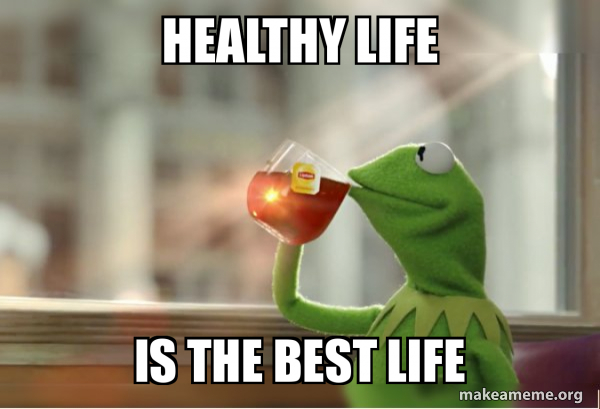